# Introduction

### Problem statement
* Current system is to call customers once bill is unpaid 5 days past due date.
* This strategy is no longer feasable with recent growth.
* Want to look at implementing new, separate strategies for different customer segments, based on December 2021 billing data.

### How will this help Spendy?
* Segmenting customers and prioritizing those who need heavy followup vs. customers who are highly likely to pay without extra contact will free up valuable collection resources for Spendy
* Model can possibly be used in conjunction with current signup process to set more accuracte spending limits, improve approval rates for potential good users, etc.

# Setup and Loading Datasets

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install pandas-profiling
# !pip install sklearn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pandas_profiling import ProfileReport
import glob

from sklearn.cluster import KMeans

In [3]:
matplotlib.rcParams['figure.figsize'] = (18, 5)
matplotlib.rcParams['font.size'] = 12

pd.set_option('display.max_colwidth', None)

In [4]:
# gather all .csv files provided and combine filenames into dictionary with matching variable names (just stripping the ".csv")
files = {}
for file in glob.glob("*.csv"):
    files[file.split('.')[0]] = file

In [5]:
files

{'data_dictionary': 'data_dictionary.csv',
 'current_bill': 'current_bill.csv',
 'customer': 'customer.csv',
 'bill_history': 'bill_history.csv',
 'transaction_history': 'transaction_history.csv',
 'high_risk_20211201': 'high_risk_20211201.csv',
 'med_risk_20211201': 'med_risk_20211201.csv',
 'low_risk_20211201': 'low_risk_20211201.csv'}

In [6]:
# read into Pandas using dictionary created above
for key,value in files.items():
    globals()[f'{key}']=pd.read_csv(f'{value}')

In [7]:
# useful to have as a reference
data_dictionary

,Table,Field,Description
0,current_bill,customer_id,unique identifier for the customer using Spendy
1,current_bill,bill_id,identifier for each customers bill
2,current_bill,amount_billed,"amount Spendy has billed to the customer, this amount could be made up of multiple transactions"
3,current_bill,date_due,the due date that the bill should be paid by
4,current_bill,date_paid,"the date the bill was paid, null where the bill is not yet paid"
5,bill_history,customer_id,unique identifier for the customer using Spendy
6,bill_history,bill_id,identifier for each customers bill
7,bill_history,amount_billed,"amount Spendy has billed to the customer, this amount could be made up of multiple transactions"
8,bill_history,date_due,the due date that the bill should be paid by
9,bill_history,date_paid,"the date the bill was paid, null where the bill is not yet paid"


## current_bill

In [8]:
current_bill.head()

,customer_id,bill_id,amount_billed,date_due,date_paid
0,customer_1,bill_2021-12-01,3480,2021-12-10,2022-01-10
1,customer_2,bill_2021-12-01,20635,2021-12-10,2022-01-10
2,customer_3,bill_2021-12-01,33078,2021-12-10,2022-01-10
3,customer_4,bill_2021-12-01,6515,2021-12-10,2021-12-16
4,customer_5,bill_2021-12-01,13518,2021-12-10,2021-12-16


In [9]:
ProfileReport(current_bill,title='current_bill report').to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Observations
* Dates are stored as strings
* ~15% of current bills are unpaid
* Seems to be mostly low- to mid-value purchases (mean of ~9000JPY)

## bill_history

In [10]:
bill_history.head()

,customer_id,bill_id,amount_billed,date_due,date_paid
0,customer_1,bill_2021-10-01,9969,2021-10-10,2021-10-10
1,customer_1,bill_2021-07-01,16814,2021-07-10,2021-07-11
2,customer_1,bill_2021-02-01,8511,2021-02-10,2021-02-14
3,customer_2,bill_2021-11-01,10746,2021-11-10,2021-11-27
4,customer_2,bill_2021-10-01,15953,2021-10-10,2021-10-29


In [11]:
ProfileReport(bill_history, title='bill_history report', explorative=True).to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Observations
* Dates are stored as strings
* A few missing values for date_paid; so some customers already have a history defaulting

## customer
Pretty self explanatory. Does not need full pandas profile, just going to check on range of date_account_opened (assuming that this one is also a string)

In [12]:
customer.head()

,customer_id,date_account_opened,gender
0,customer_1,2021-01-05,Male
1,customer_2,2020-10-13,Male
2,customer_3,2017-12-30,Female
3,customer_4,2020-12-04,Male
4,customer_5,2017-07-03,Male


In [13]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3998 entries, 0 to 3997
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   customer_id          3998 non-null   object
 1   date_account_opened  3998 non-null   object
 2   gender               3998 non-null   object
dtypes: object(3)
memory usage: 93.8+ KB


In [14]:
customer['date_account_opened'].describe(datetime_is_numeric=True)

count           3998
unique          1227
top       2021-11-02
freq              68
Name: date_account_opened, dtype: object

### Observations
* Might be a handful of old accounts but most seem to be created within the last year

## transaction_history

In [15]:
transaction_history.head()

,customer_id,transaction_id,date_transaction,amount_transaction,category,merchant_account_age,address,email_domain,due_month
0,customer_1,transaction_1,2021-11-10,3480,Fashion,NaN,KANAGAWA KEN,gmail.com,2021-12-01
1,customer_1,transaction_2,2021-09-15,4685,Fashion,NaN,KANAGAWA KEN,gmail.com,2021-10-01
2,customer_1,transaction_3,2021-09-05,4284,Fashion,NaN,KANAGAWA KEN,gmail.com,2021-10-01
3,customer_1,transaction_4,2021-09-05,1000,Fashion,NaN,KANAGAWA KEN,gmail.com,2021-10-01
4,customer_1,transaction_5,2021-06-23,16814,Fashion,NaN,KANAGAWA KEN,gmail.com,2021-07-01


In [16]:
ProfileReport(transaction_history, title='transaction_history report', explorative=True).to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Obvservations
* Like other tables, dates are stored as strings (categorical) rather than DateTime
* Merchant account age missing from most entries
* Address data incomplete but only by slight margin

Let's quickly take a closer look at the distribution of due_month

<AxesSubplot:title={'center':'due_month distribution'}>

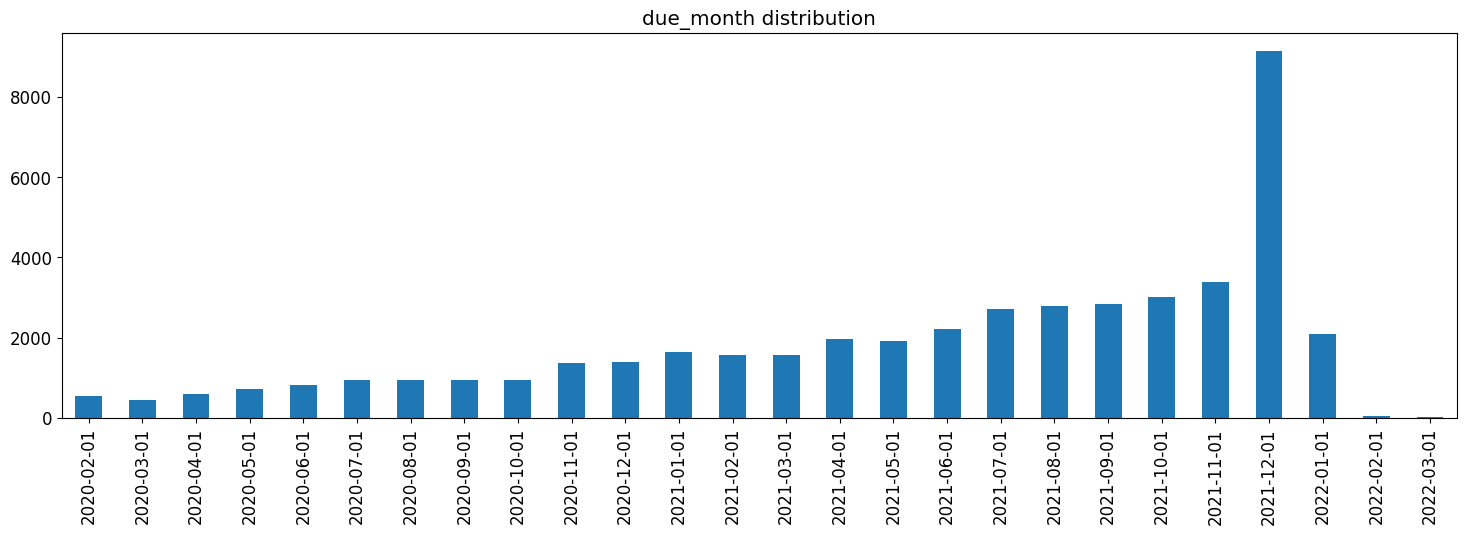

In [17]:
transaction_history['due_month'].value_counts().sort_index().plot(kind='bar',title='due_month distribution')

### Obvservations
* Lots of activity in 2021-12-01
    * Could be real growth or just a result of this task being based around 2021-12-01 overdue bills
* Growth trending up for majority of observation period
* Seems to include data for bills after 2021-12-01, however current analysis only concerns this month so will trim upper end in a later step

# Data Processing
### Things to take care of:
* Convert strings to datetimes
* Add new columns for later analysis
    * pay_delta - difference between date_paid and date_due (negative value is paid early, positive is late)
    * due_month - need a common index to link bill_history/current_bill tables to transaction_history table
    * period - will want to concat the two billing tables, so this will be useful for quickly identifying which table an entry was originally from
        * 'old' for transactions in bill_history, 'cur' for transactions in current_bill

In [18]:
# Cleaning up datatypes:
# All dates as datetime
# New columns added

current_bill['date_due'] = pd.to_datetime(current_bill['date_due'])
current_bill['date_paid'] = pd.to_datetime(current_bill['date_paid'])
current_bill['pay_delta'] = (current_bill['date_paid'] - current_bill['date_due']).dt.days
current_bill['due_month'] = current_bill['bill_id'].str.lstrip('bill_').apply(lambda x: pd.to_datetime(x))
current_bill['period'] = 'cur'

bill_history['date_due'] = pd.to_datetime(bill_history['date_due'])
bill_history['date_paid'] = pd.to_datetime(bill_history['date_paid'])
bill_history['pay_delta'] = (bill_history['date_paid'] - bill_history['date_due']).dt.days
bill_history['due_month'] = bill_history['bill_id'].str.lstrip('bill_').apply(lambda x: pd.to_datetime(x))
bill_history['period'] = 'old'

customer['date_account_opened'] = pd.to_datetime(customer['date_account_opened'])

transaction_history['date_transaction'] = pd.to_datetime(transaction_history['date_transaction'])
transaction_history['due_month'] = pd.to_datetime(transaction_history['due_month'])

### Let's use the newly added date_delta to see a distribution of payment delays

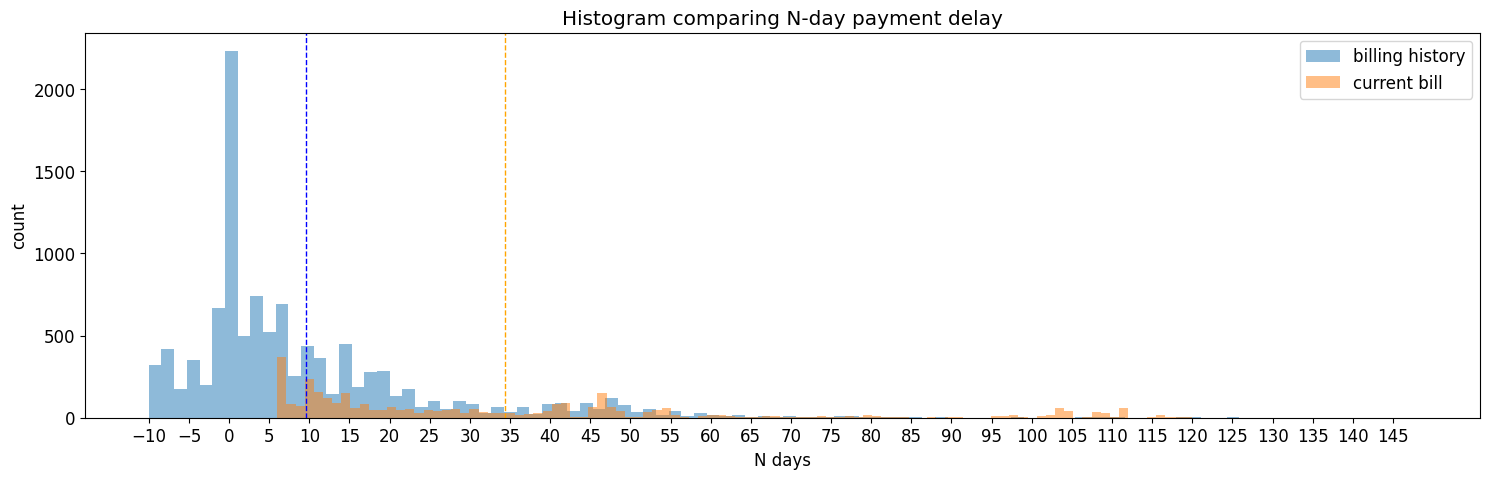

In [19]:
plt.hist(bill_history['pay_delta'],bins=100,alpha=0.5,label='billing history')
plt.axvline(bill_history['pay_delta'].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.hist(current_bill['pay_delta'],bins=100,alpha=0.5,label='current bill')
plt.axvline(current_bill['pay_delta'].mean(), color='orange', linestyle='dashed', linewidth=1)
plt.title('Histogram comparing N-day payment delay')
plt.xlabel('N days')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.xticks(np.arange(min(bill_history['pay_delta']), max(bill_history['pay_delta'])+1, 5))
plt.show()

### Observations
* billing_history data has quite a long tail
    * Mode value is 0 days delay (so on-time), but mean is ~10 days delay, with max value stretching to the 100s
* As expected, current_bill only has bills from accounts that are 5+ days late
    * Mean value is around 1 month late
    
    
    
### Going to go ahead and concat the two billing tables into all_bills:

In [20]:
all_bills = pd.concat([bill_history,current_bill])

# Comibining the data and using new features
Here I will create a new grouped table (hist_g) based on the following conditions:
* Only transactions in or before 2021-12-01
* Grouping transactions by customer, due month, and purchase category
* Will then merge this with the other tables
    * Gender data from customer
    * Billing data from all_bills

In [21]:
hist_g = transaction_history.query('due_month <="2021-12-01"').groupby(['customer_id','due_month','category']).agg({'transaction_id':'count','amount_transaction':'sum'}).rename(columns={'transaction_id':'transaction_count','amount_transaction':'amount'})
hist_g = hist_g.reset_index().merge(customer[['customer_id','date_account_opened','gender']], on='customer_id', how='left')\
    .merge(all_bills[['customer_id','due_month','bill_id','amount_billed','date_due','date_paid','pay_delta','period']], on=['customer_id','due_month'], how='left')

In [22]:
hist_g

,customer_id,due_month,category,transaction_count,amount,date_account_opened,gender,bill_id,amount_billed,date_due,date_paid,pay_delta,period
0,customer_1,2021-02-01,Fashion,2,8511,2021-01-05,Male,bill_2021-02-01,8511,2021-02-10,2021-02-14,4.0,old
1,customer_1,2021-07-01,Fashion,1,16814,2021-01-05,Male,bill_2021-07-01,16814,2021-07-10,2021-07-11,1.0,old
2,customer_1,2021-10-01,Fashion,3,9969,2021-01-05,Male,bill_2021-10-01,9969,2021-10-10,2021-10-10,0.0,old
3,customer_1,2021-12-01,Fashion,1,3480,2021-01-05,Male,bill_2021-12-01,3480,2021-12-10,2022-01-10,31.0,cur
4,customer_10,2021-12-01,Other,1,2860,2021-11-04,Female,bill_2021-12-01,2860,2021-12-10,2022-01-07,28.0,cur
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16655,customer_998,2021-11-01,Fashion,3,12845,2021-09-24,Female,bill_2021-11-01,4859,2021-11-10,2021-11-14,4.0,old
16656,customer_998,2021-12-01,Fashion,8,21888,2021-09-24,Female,bill_2021-12-01,16798,2021-12-10,NaT,NaN,cur
16657,customer_999,2020-12-01,Marketplace,1,41800,2019-09-27,Female,bill_2020-12-01,41800,2020-12-10,2020-12-14,4.0,old
16658,customer_999,2021-11-01,Mall,1,6634,2019-09-27,Female,bill_2021-11-01,6634,2021-11-10,2021-11-10,0.0,old


* Account age should be useful to have

In [23]:
hist_g['account_age'] = (hist_g['date_due'] - hist_g['date_account_opened']).dt.days

* Might be useful to track Nth transaction per customer (dense rank), so I'll add that here

In [24]:
hist_g = hist_g.join(hist_g.groupby('customer_id')['due_month'].rank('dense').rename('customer_n_transaction'))

* Some customers might have multiple purchase categories per month, want to just confirm that these are handled correctly in merged table

In [25]:
# Group by customer_id and due_month, then count # of categories
hist_g.groupby(['customer_id','due_month'])['category'].count().sort_values(ascending=False).head(3)

customer_id    due_month 
customer_3077  2021-09-01    5
customer_2807  2021-06-01    4
customer_689   2021-02-01    4
Name: category, dtype: int64

In [26]:
# Looks like there are some customers with multiple categories in one month. 
# Let's verify that the data looks OK
hist_g.query('customer_id=="customer_3077"').head(10)

,customer_id,due_month,category,transaction_count,amount,date_account_opened,gender,bill_id,amount_billed,date_due,date_paid,pay_delta,period,account_age,customer_n_transaction
9463,customer_3077,2020-02-01,C2C,1,440,2019-12-25,Female,bill_2020-02-01,440,2020-02-10,2020-02-04,-6.0,old,47,1.0
9464,customer_3077,2020-04-01,C2C,4,2076,2019-12-25,Female,bill_2020-04-01,2076,2020-04-10,2020-04-02,-8.0,old,107,2.0
9465,customer_3077,2020-05-01,C2C,6,10680,2019-12-25,Female,bill_2020-05-01,11740,2020-05-10,2020-05-04,-6.0,old,137,3.0
9466,customer_3077,2020-05-01,Cosmetics,1,1760,2019-12-25,Female,bill_2020-05-01,11740,2020-05-10,2020-05-04,-6.0,old,137,3.0
9467,customer_3077,2020-06-01,C2C,2,4900,2019-12-25,Female,bill_2020-06-01,12744,2020-06-10,2020-06-04,-6.0,old,168,4.0
9468,customer_3077,2020-06-01,Fashion,3,7932,2019-12-25,Female,bill_2020-06-01,12744,2020-06-10,2020-06-04,-6.0,old,168,4.0
9469,customer_3077,2020-07-01,C2C,1,2500,2019-12-25,Female,bill_2020-07-01,7146,2020-07-10,2020-07-10,0.0,old,198,5.0
9470,customer_3077,2020-07-01,Cosmetics,1,1815,2019-12-25,Female,bill_2020-07-01,7146,2020-07-10,2020-07-10,0.0,old,198,5.0
9471,customer_3077,2020-07-01,Fashion,1,2831,2019-12-25,Female,bill_2020-07-01,7146,2020-07-10,2020-07-10,0.0,old,198,5.0
9472,customer_3077,2020-08-01,C2C,1,1600,2019-12-25,Female,bill_2020-08-01,5383,2020-08-10,2020-08-10,0.0,old,229,6.0


### Using the nth transaction data
* I'll use this new data field to see how many transactions each customer has

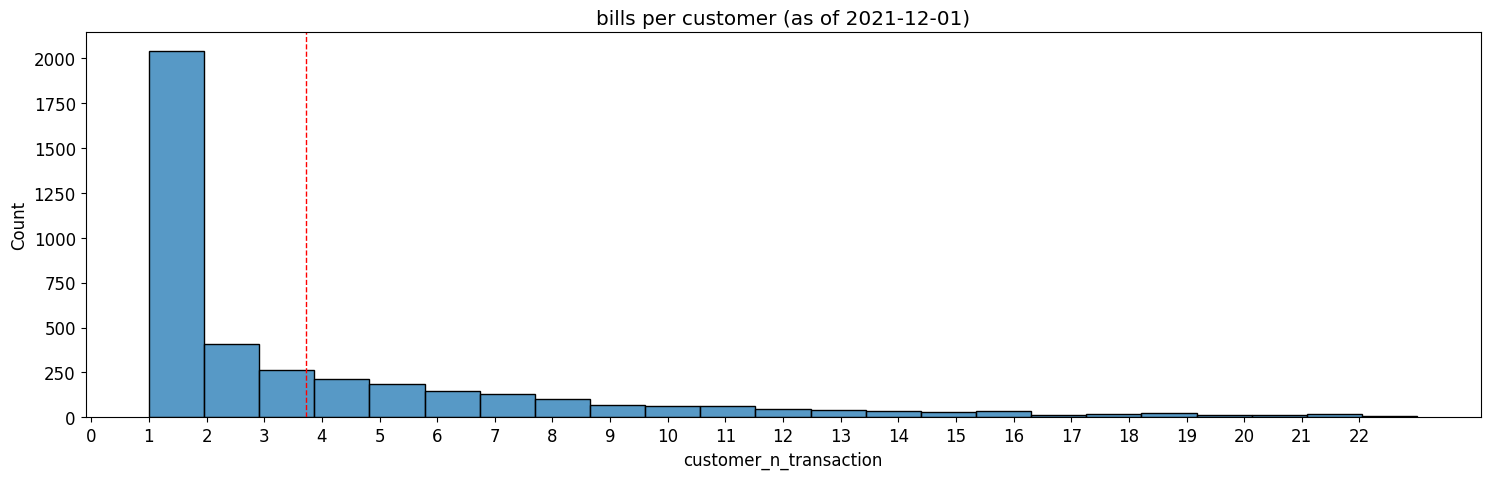

In [27]:
graph = hist_g.groupby('customer_id')['customer_n_transaction'].max()
sns.histplot(data=graph,bins=int(max(graph))).set(title='bills per customer (as of 2021-12-01)')
plt.axvline(graph.mean(), color='red', linestyle='dashed', linewidth=1)
plt.xticks(np.arange(min(graph)-1, max(graph), 1))
plt.show()

### Observations
* Mean is ~3 transactions
* Most users are one-and-done
    * Might be difficult to use history to predict 2021-12-01 defaults if 'history' is only 1 month
    

### Looking at similar metric, transactions per each individual monthly bill

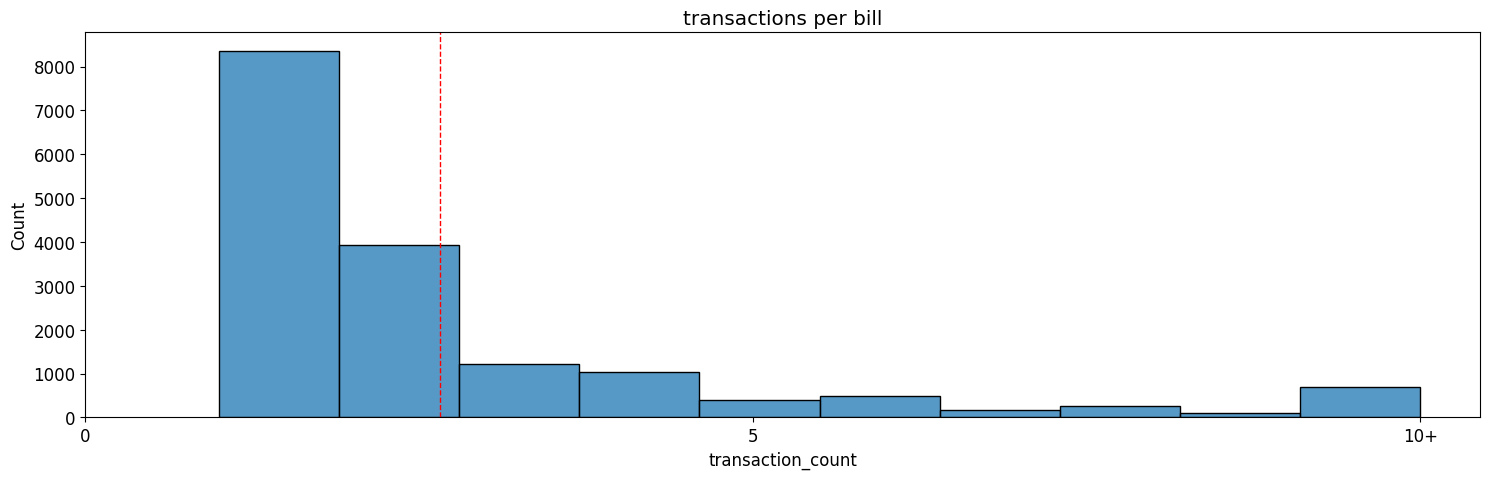

In [28]:
graph = hist_g.copy()
graph.loc[graph['transaction_count'] >= 10, 'transaction_count'] = 10
graph = graph['transaction_count']
sns.histplot(data=graph,bins=int(max(graph))).set(title='transactions per bill')
plt.axvline(hist_g['transaction_count'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.xticks(np.arange(min(graph)-1, max(graph)+1, 5), ['0','5','10+'])
plt.show()

### Observations
* Similar to above, most customers tend to keep things simple: 1-2 Spendy transactions in a billing period

### Let's take a look at pay delta distributions
The current_bill dataset only contains bills over 5 days past due, but still good to compare to the bill_history baseline

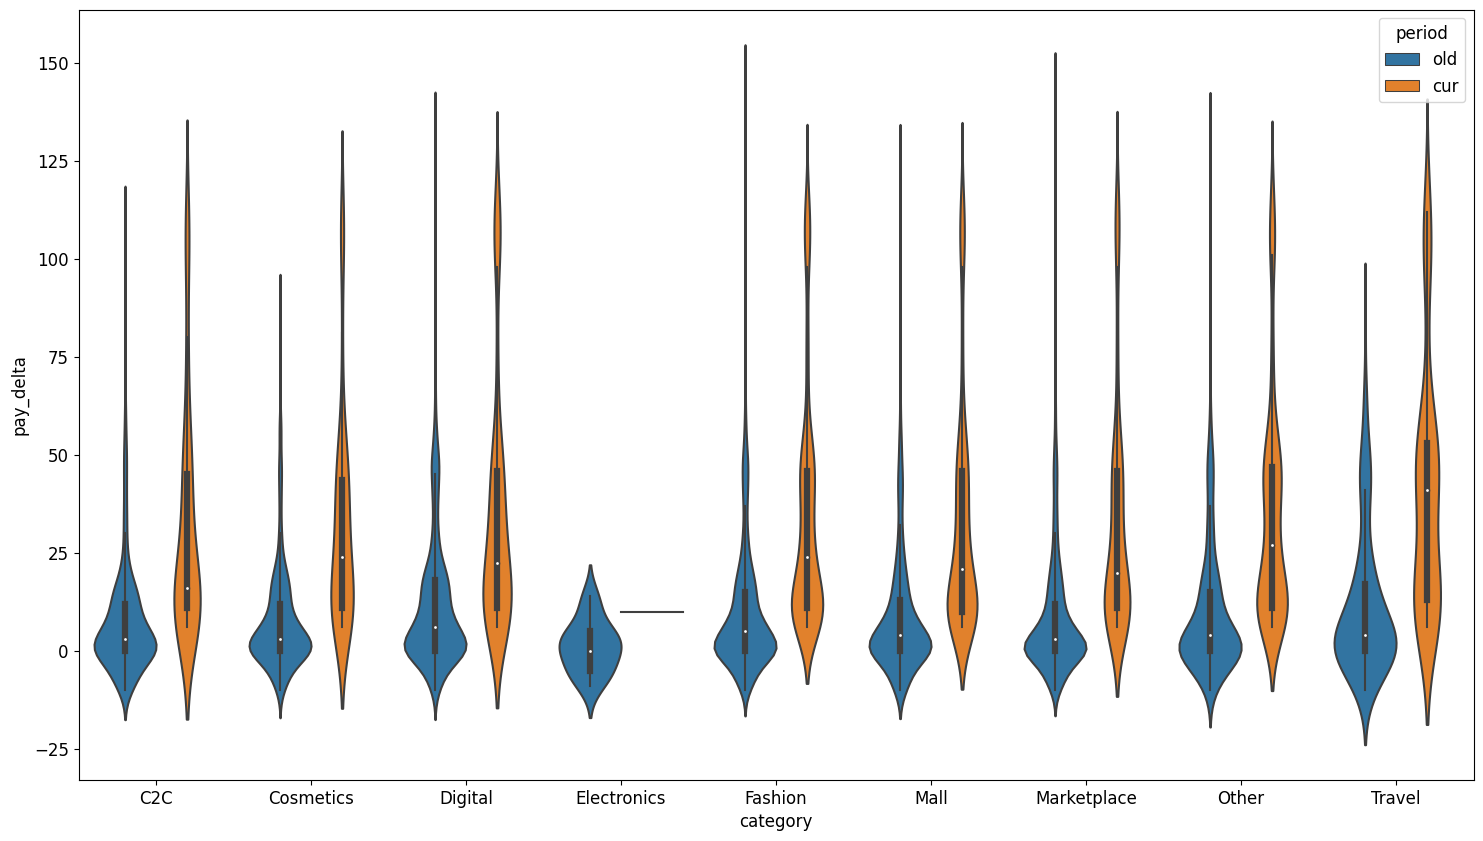

In [29]:
plt.figure(figsize=(18,10))
sns.violinplot(data=hist_g.sort_values('category',ascending=True), x='category', y='pay_delta', hue='period')
plt.show()

### Observations
* Many categories in 'old' segment have a mean pay_delta that is slightly above zero, however Electronics seems to be an exception to this
* Travel, Other, Fashion, Cosmetics seem to be the worst offenders for the late current bills
    * Fashion, Cosmetics makes sense; likely to be impulse buys
    * Travel seems a bit out of place. Could be small sample size

### Purchases per category
* Following off the above, let's look at how many purchases are in each category for both old bills and current bills

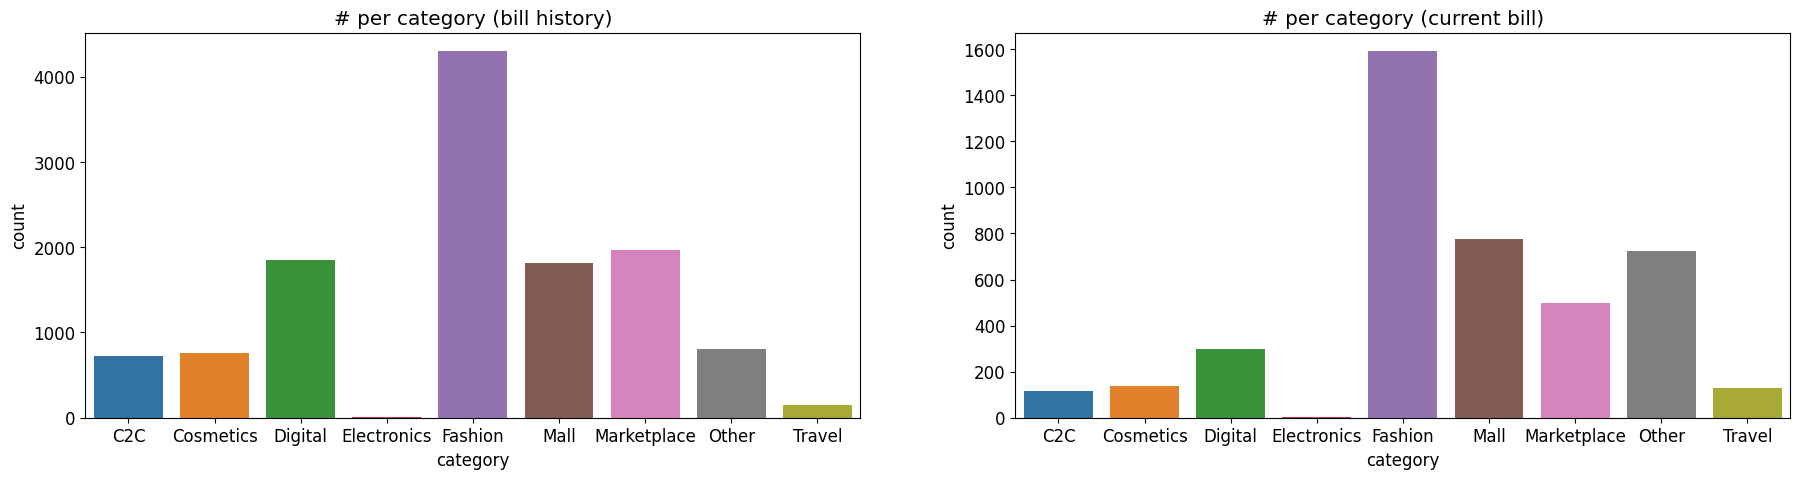

In [30]:
graph = hist_g.groupby(['category','period'])['bill_id'].count().rename('count').reset_index()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(22,5))
sns.barplot(data=graph.query('period=="old"'), x='category', y='count', ax=ax1).set(title='# per category (bill history)')
sns.barplot(data=graph.query('period=="cur"'), x='category', y='count', ax=ax2).set(title='# per category (current bill)')
plt.show()

### Observations
* As predicted above, Travel category is very small sample size
* Fashion makes up majority of purchases
* Curious what Mall category entails, but also relatively high, especially in current bill

### Categorizing pay_delta
* It seems like it will be useful to make more concise categories for "timeliness" of bill payment
    * on_time = paid on or before the due date
    * late_ok = paid late, but before the 5 day call threshold
    * late_bad = paid 5 days late or more

In [31]:
hist_g.loc[hist_g['pay_delta']<5,'timely'] = 'late_ok'
hist_g.loc[hist_g['pay_delta']<=0,'timely'] = 'on_time'
hist_g.loc[hist_g['pay_delta']>=5,'timely'] = 'late_bad'

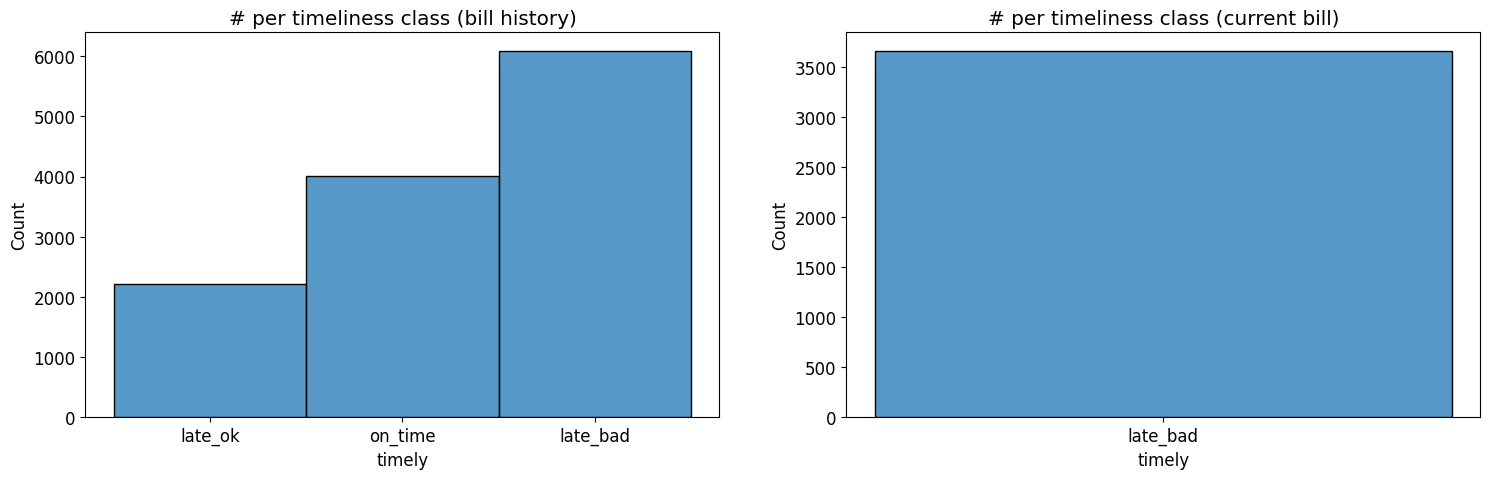

In [32]:
# plt.figure(figsize=(10,5))
fig, (ax1,ax2) = plt.subplots(1,2)
sns.histplot(data=hist_g.query('period=="old"'), x='timely', ax=ax1).set(title='# per timeliness class (bill history)')
sns.histplot(data=hist_g.query('period=="cur"'), x='timely', ax=ax2).set(title='# per timeliness class (current bill)')
plt.show()

### Observations
* If we consider late_ok to be "acceptable", there is a fairly even split between acceptable and unacceptable lateness
* As expected, current_bill only contains late_bad bills

### Looking at default rate as a function of monthly transaction count
Now it's time to look at the "default rate", or percentage of late_bad bills. Here we'll look at it as a function of monthly transaction count

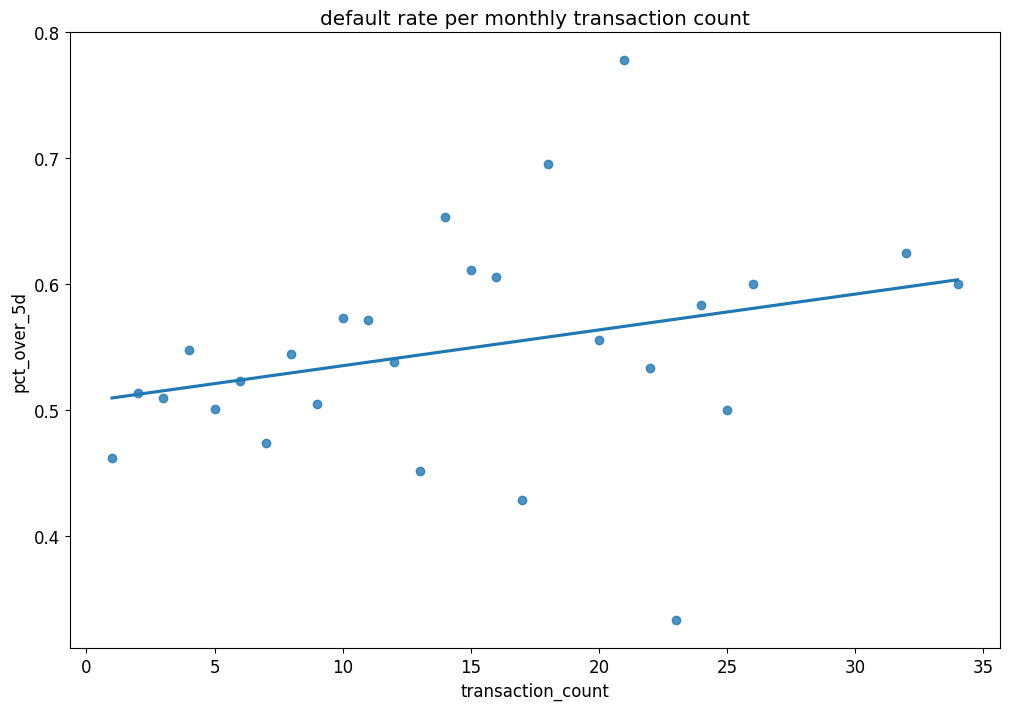

In [33]:
graph = hist_g.query('period=="old"').groupby(['transaction_count','timely'])['bill_id'].count().reset_index()\
        .pivot(index='transaction_count', columns='timely', values='bill_id')\
        .apply(lambda x: x[0] / (x[1]+x[2]+x[0]), axis=1).rename('pct_over_5d').reset_index()
plt.figure(figsize=(12,8))
sns.regplot(data=graph, x='transaction_count', y='pct_over_5d', ci=None).set(title='default rate per monthly transaction count')
plt.show()

### Default rate per monthly transaction count, by category

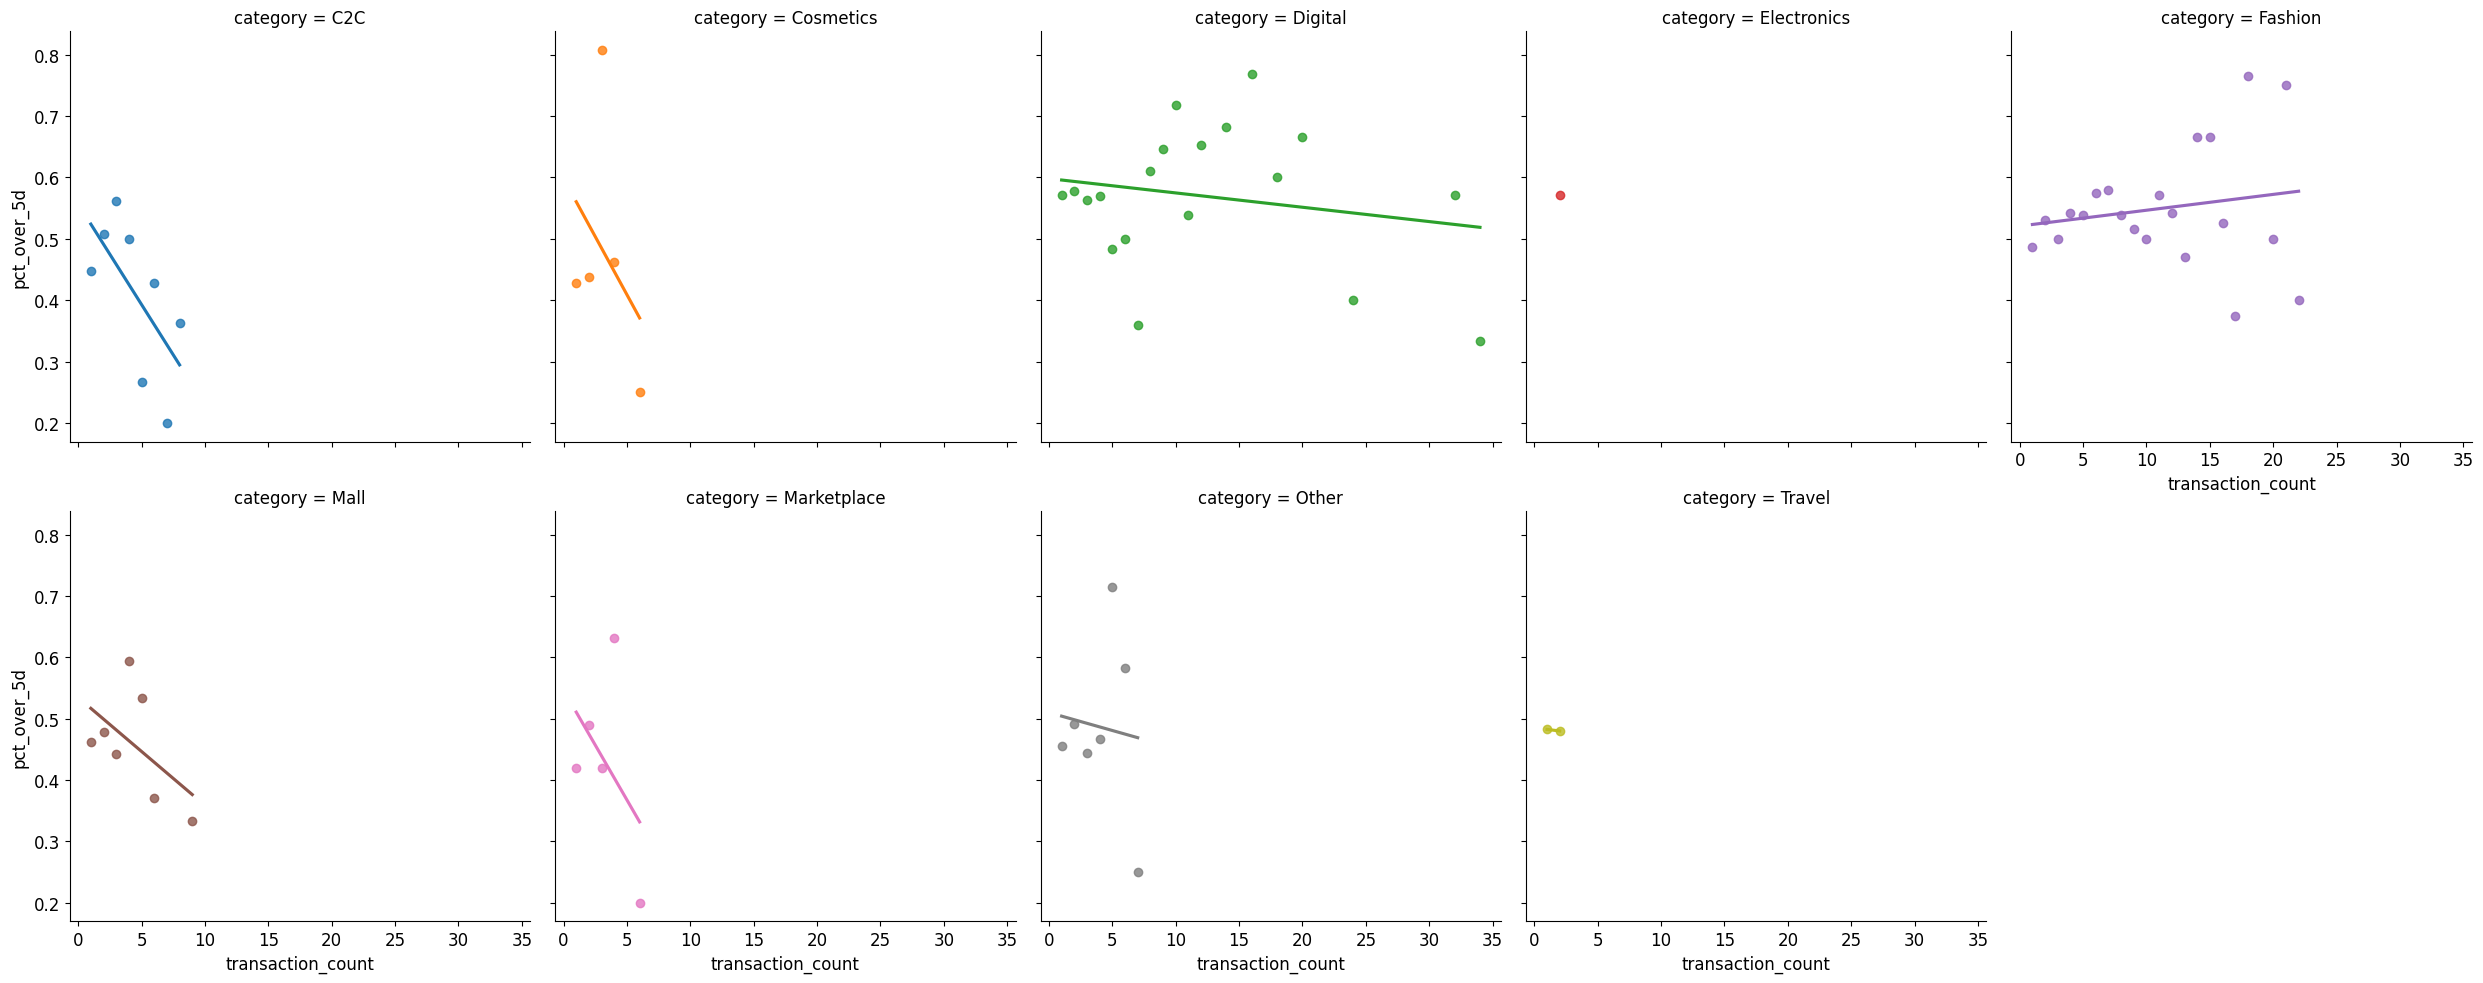

In [34]:
graph = hist_g.query('period=="old"').groupby(['category','transaction_count','timely'])['bill_id'].count().reset_index()\
        .pivot(index=['category','transaction_count'], columns='timely', values='bill_id')\
        .apply(lambda x: x[0] / (x[1]+x[2]+x[0]), axis=1).rename('pct_over_5d').reset_index()
sns.lmplot(data=graph, x='transaction_count', y='pct_over_5d', hue='category', col='category', ci=None, col_wrap=5)
plt.show()

### Observations
* Overall trend is that higher monthly transaction count leads to higher default rate
    * However this is heavily influenced by a few factors:
        * Low sample size of high-transaction-count bills
        * Average is influenced by majority category of Fashion
* In general, Digital and Fashion could be considered as "risky" categories
    * Regardless of trend based on transaction_count, over 50% default chance

### Default rate as a function of customer Nth transaction
Let's look at the above, but this time in relation to the amount of monthly bills that a customer has accrued (Nth transaction on the platform).
This is essentially account age.

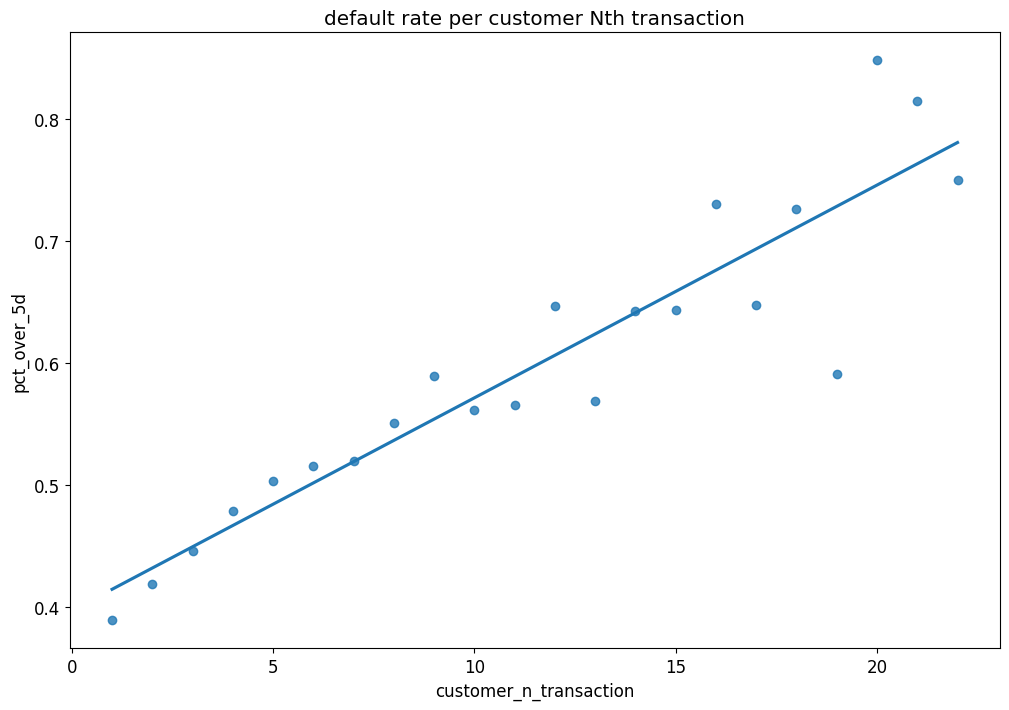

In [35]:
graph = hist_g.query('period=="old"').groupby(['customer_n_transaction','timely'])['bill_id'].count().reset_index()\
        .pivot(index='customer_n_transaction', columns='timely', values='bill_id')\
        .apply(lambda x: x[0] / (x[1]+x[2]+x[0]), axis=1).rename('pct_over_5d').reset_index()
plt.figure(figsize=(12,8))
sns.regplot(data=graph, x='customer_n_transaction', y='pct_over_5d', ci=None).set(title='default rate per customer Nth transaction')
plt.show()

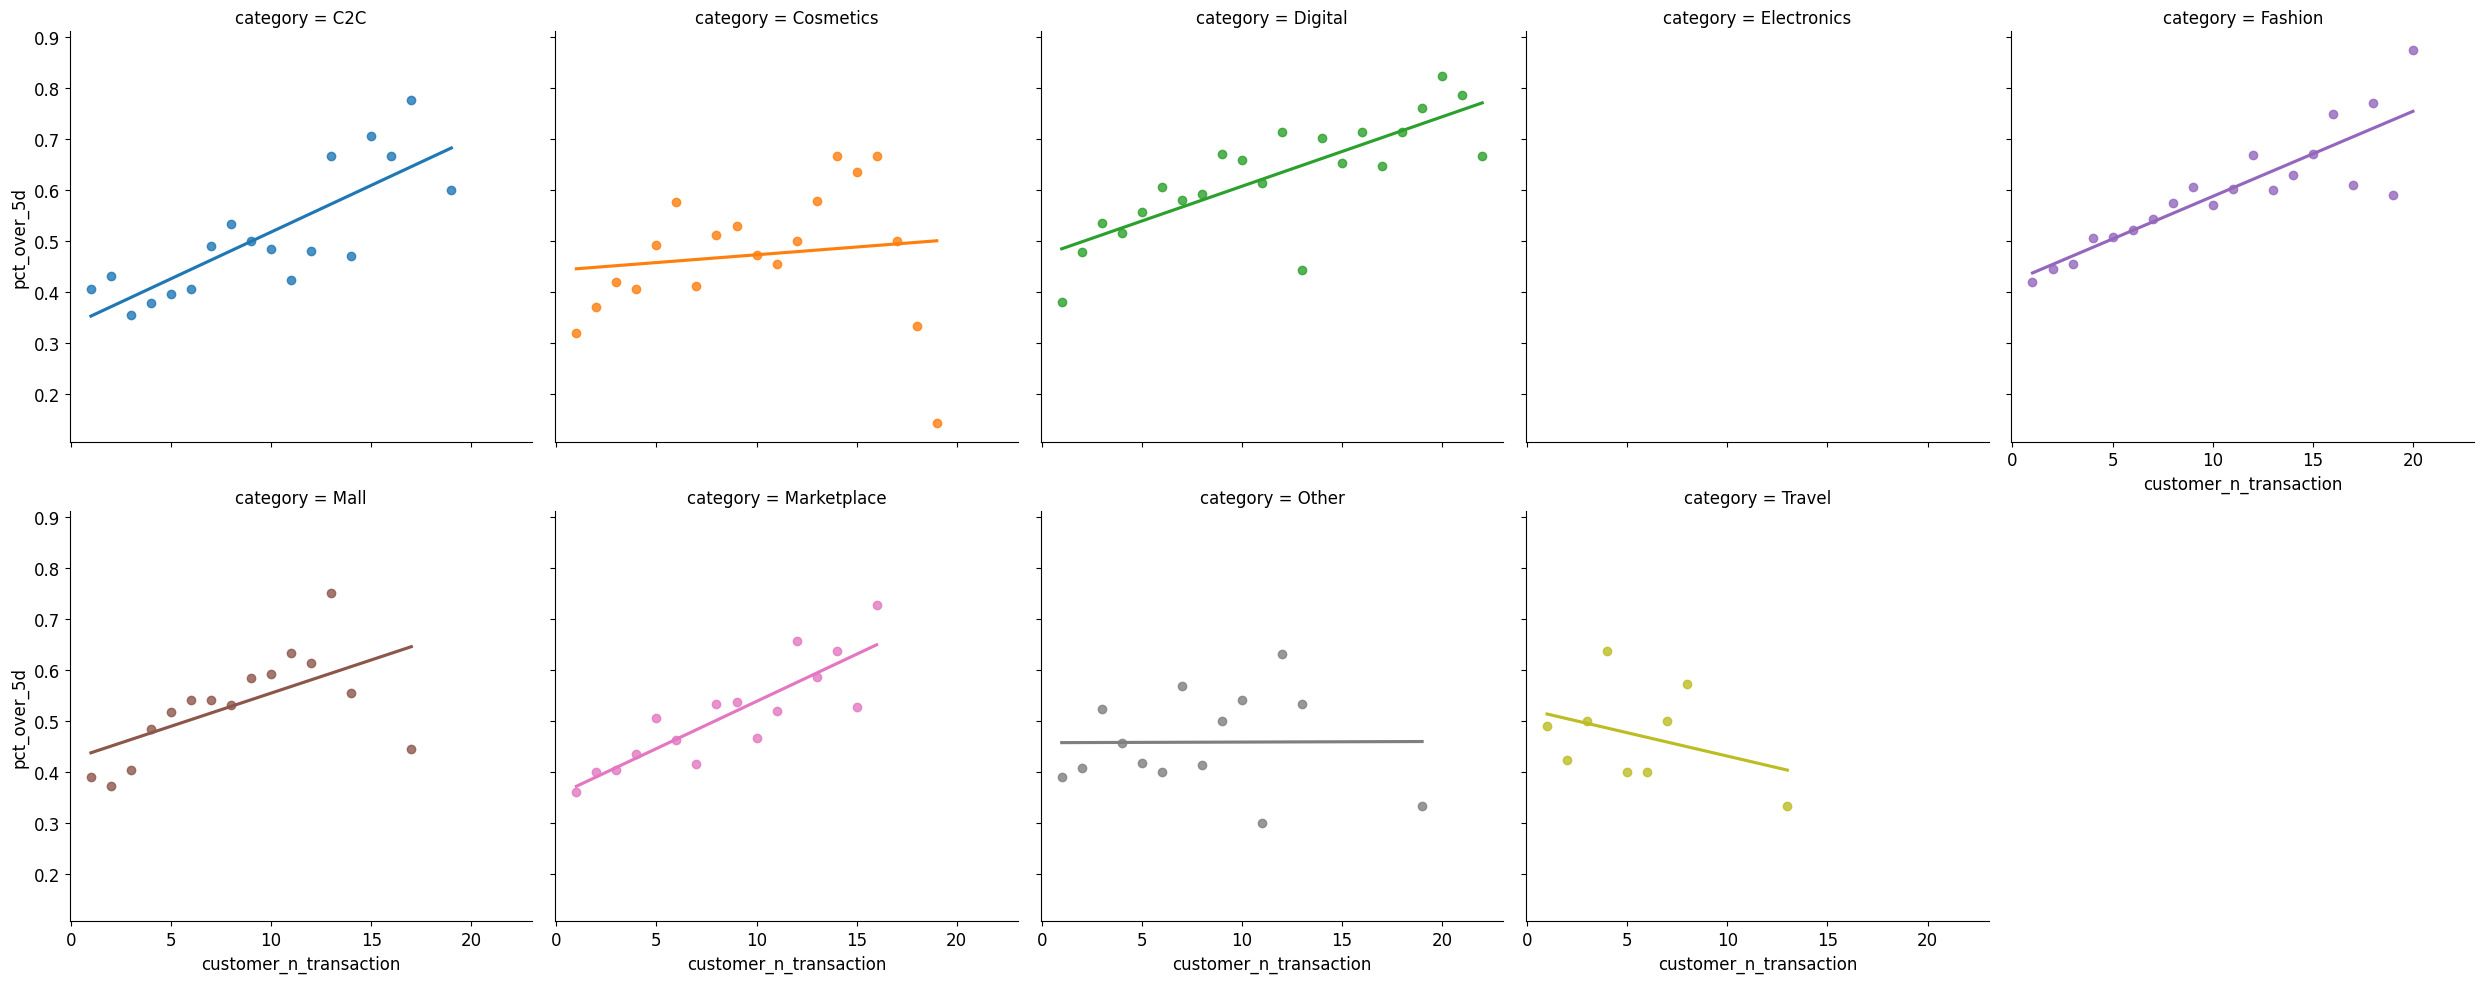

In [36]:
graph = hist_g.query('period=="old"').groupby(['category','customer_n_transaction','timely'])['bill_id'].count().reset_index()\
        .pivot(index=['category','customer_n_transaction'], columns='timely', values='bill_id')\
        .apply(lambda x: x[0] / (x[1]+x[2]+x[0]), axis=1).rename('pct_over_5d').reset_index()
sns.lmplot(data=graph, x='customer_n_transaction', y='pct_over_5d', hue='category', col='category', ci=None, col_wrap=5)
plt.show()

### Observations
* Interesting that the longer a customer stays with the platform, the more likely they are to default
* Similar to the previous section, Fashion and Digital seem to have the highest probability to default

In [37]:
hist_g

,customer_id,due_month,category,transaction_count,amount,date_account_opened,gender,bill_id,amount_billed,date_due,date_paid,pay_delta,period,account_age,customer_n_transaction,timely
0,customer_1,2021-02-01,Fashion,2,8511,2021-01-05,Male,bill_2021-02-01,8511,2021-02-10,2021-02-14,4.0,old,36,1.0,late_ok
1,customer_1,2021-07-01,Fashion,1,16814,2021-01-05,Male,bill_2021-07-01,16814,2021-07-10,2021-07-11,1.0,old,186,2.0,late_ok
2,customer_1,2021-10-01,Fashion,3,9969,2021-01-05,Male,bill_2021-10-01,9969,2021-10-10,2021-10-10,0.0,old,278,3.0,on_time
3,customer_1,2021-12-01,Fashion,1,3480,2021-01-05,Male,bill_2021-12-01,3480,2021-12-10,2022-01-10,31.0,cur,339,4.0,late_bad
4,customer_10,2021-12-01,Other,1,2860,2021-11-04,Female,bill_2021-12-01,2860,2021-12-10,2022-01-07,28.0,cur,36,1.0,late_bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16655,customer_998,2021-11-01,Fashion,3,12845,2021-09-24,Female,bill_2021-11-01,4859,2021-11-10,2021-11-14,4.0,old,47,2.0,late_ok
16656,customer_998,2021-12-01,Fashion,8,21888,2021-09-24,Female,bill_2021-12-01,16798,2021-12-10,NaT,NaN,cur,77,3.0,NaN
16657,customer_999,2020-12-01,Marketplace,1,41800,2019-09-27,Female,bill_2020-12-01,41800,2020-12-10,2020-12-14,4.0,old,440,1.0,late_ok
16658,customer_999,2021-11-01,Mall,1,6634,2019-09-27,Female,bill_2021-11-01,6634,2021-11-10,2021-11-10,0.0,old,775,2.0,on_time


<AxesSubplot:xlabel='account_age', ylabel='pay_delta'>

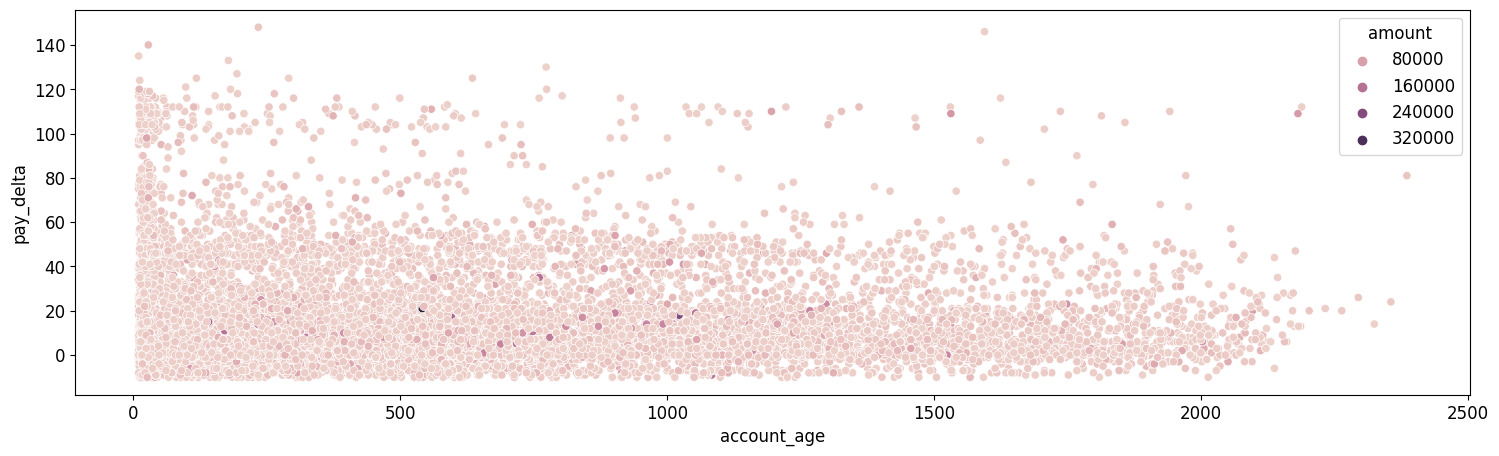

In [38]:
sns.scatterplot(data=hist_g, x='account_age', y='pay_delta' ,hue='amount')

# Prediction modeling
Now that we've looked at most of the possible datapoints, let's create a model to accurately predict pay_delta

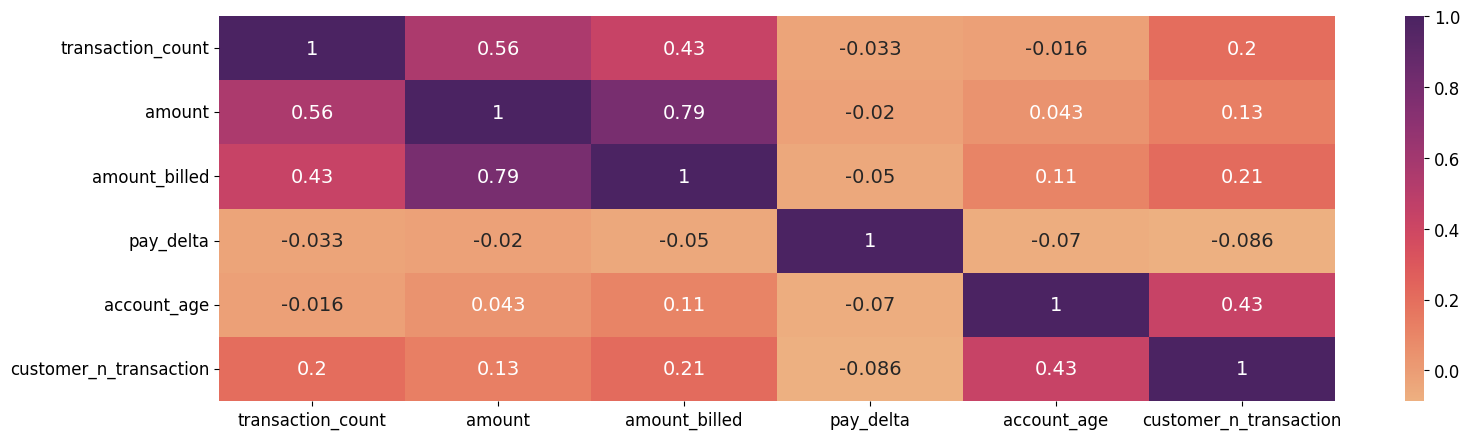

In [39]:
fig, ax = plt.subplots()
corr_matrix = hist_g.corr()
corr_heatmap = sns.heatmap(corr_matrix, cmap = "flare", annot=True, ax=ax, annot_kws={"size": 14})
plt.show()

* Looking at the correlation matrix of the numerical attributes, we can see that there aren't any extremely strong pairings. 
* Additionally, the strongest pairings are ones that are intrinsically linked anyway
    * amount <-> amount_billed
    * pay_delta <-> timely

### Model creation
Since there aren't any standout variables, we'll use the ones that I feel are most independent
* transaction_count: number of transactions in bill
* amount_billed: JPY amount of monthly bill
* account_age: age in days of account at time of bill

Category would be nice to add as well, but we'll wait to see what happens with it further down

In [40]:
cols = ['transaction_count','amount_billed','account_age']
hist_g = hist_g.dropna(axis=0)

# Using bill_history as training data, current_bill as test data
X_train = hist_g.query('period=="old"')[cols]
y_train = hist_g.query('period=="old"')['pay_delta']
X_test = hist_g.query('period=="cur"')[cols]
y_test = hist_g.query('period=="cur"')['pay_delta']

X_train

,transaction_count,amount_billed,account_age
0,2,8511,36
1,1,16814,186
2,3,9969,278
6,2,13750,28
8,1,4822,16
...,...,...,...
16652,1,6078,756
16654,1,2480,16
16655,3,4859,47
16657,1,41800,440


In [41]:
X_train.shape

(12320, 3)

In [42]:
y_train.shape

(12320,)

In [43]:
X_test.shape

(3659, 3)

In [44]:
y_test.shape

(3659,)

In [45]:
# Scaling variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)

In [46]:
# Create and fit to linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_scaled, y_train)

LinearRegression()

In [47]:
# Check on error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

mse = mean_squared_error(y_train, model.predict(train_scaled))
mae = mean_absolute_error(y_train, model.predict(train_scaled))
print("mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))

mse =  268.2046802228191  & mae =  11.50284971862471  & rmse =  16.376955767871486


In [48]:
# Model accuracy
model.score(X_test, y_test)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


-94580.90988956786

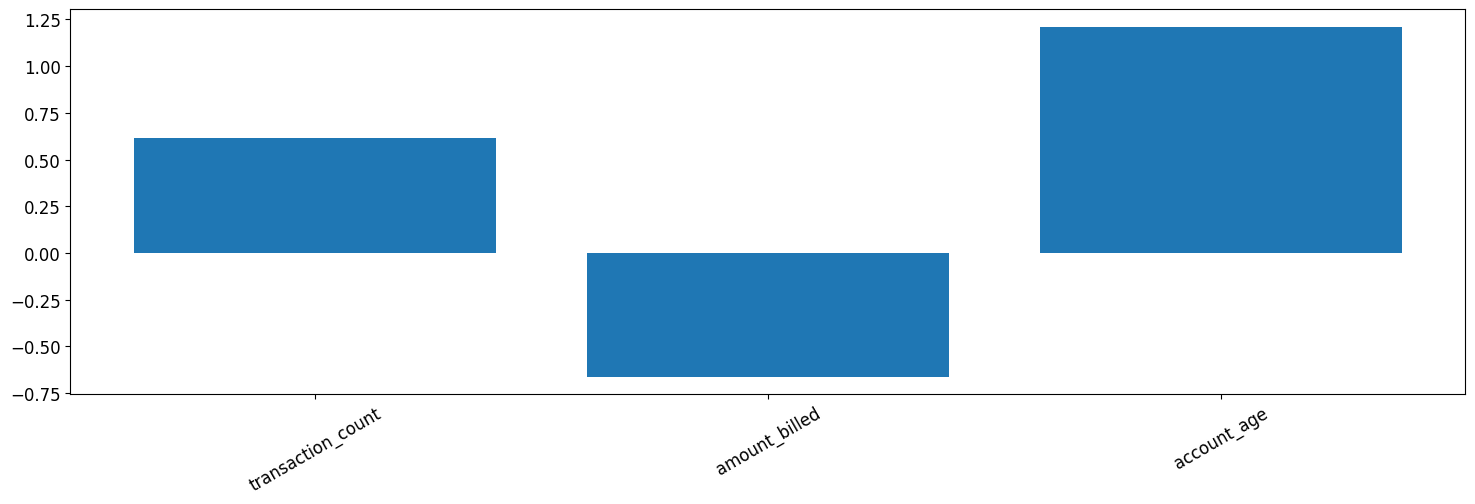

In [49]:
importance = model.coef_
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], X_train.columns.values.tolist(), rotation=30)
plt.show()

### With category component
Curious how it would look with purchase Category added back in

mse =  265.6277166373798  & mae =  11.41608307400662  & rmse =  16.298089355423837


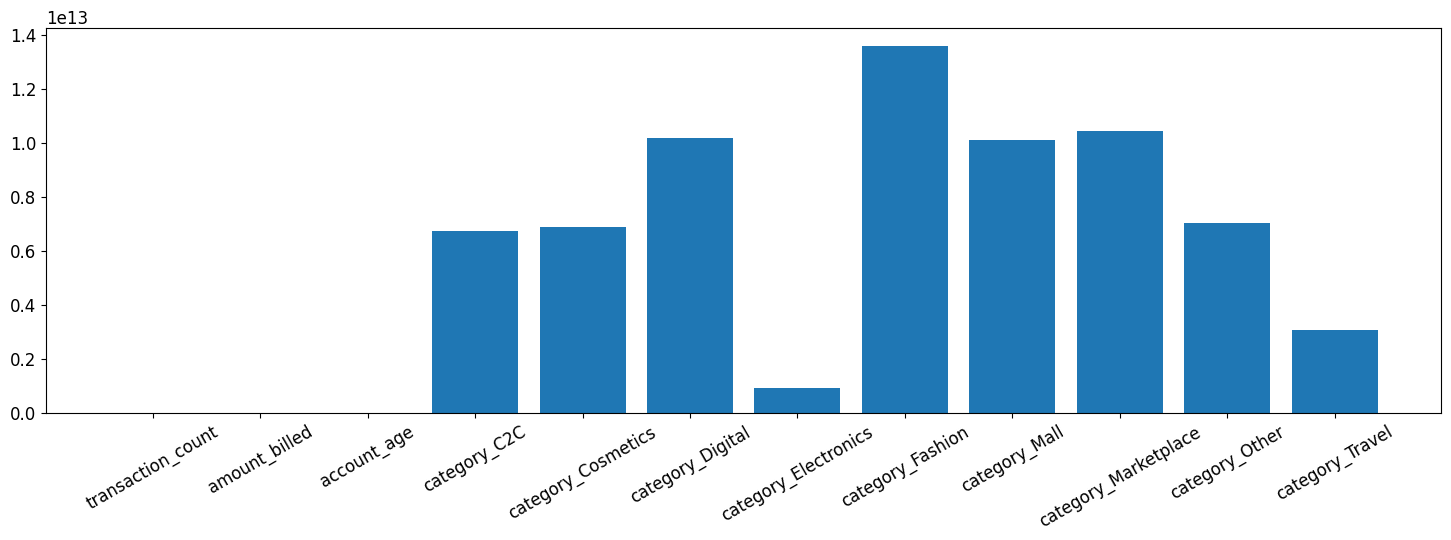

In [50]:
cols = ['transaction_count','amount_billed','account_age','category']
hist_g = hist_g.dropna(axis=0)
X_train = hist_g.query('period=="old"')[cols]
X_train = pd.get_dummies(X_train, columns=['category'], prefix='category')
y_train = hist_g.query('period=="old"')['pay_delta']
X_test = hist_g.query('period=="cur"')[cols]
y_test = hist_g.query('period=="cur"')['pay_delta']
X_test = pd.get_dummies(X_test, columns=['category'], prefix='category')
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)
model = LinearRegression()
model.fit(train_scaled, y_train)
mse = mean_squared_error(y_train, model.predict(train_scaled))
mae = mean_absolute_error(y_train, model.predict(train_scaled))
print("mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))

importance = model.coef_
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], X_train.columns.values.tolist(), rotation=30)
plt.show()

In [51]:
model.score(X_test, y_test)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


-1.3305251421289826e+23

### Observations
* Accuracy less bad than without category?
* Category overpowers all other categories
    * Fashion on top, followed closely by Marketplace, Digital, Mall

# Conclusion

Based on the quick modeling we did above, it seems account_age might be relevant. Let's take a quick look

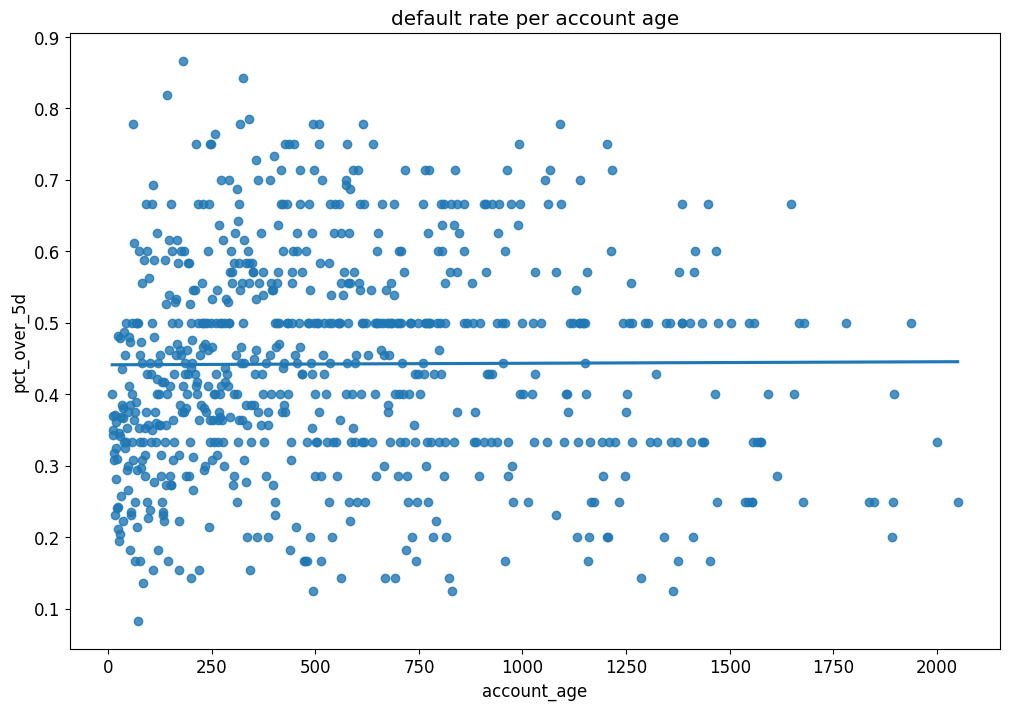

In [52]:
graph = hist_g.query('period=="old"').groupby(['account_age','timely'])['bill_id'].count().reset_index()\
        .pivot(index='account_age', columns='timely', values='bill_id')\
        .apply(lambda x: x[0] / (x[1]+x[2]+x[0]), axis=1).rename('pct_over_5d').reset_index()
plt.figure(figsize=(12,8))
sns.regplot(data=graph, x='account_age', y='pct_over_5d', ci=None).set(title='default rate per account age')
plt.show()

Maybe not so useful for segmenting customers!

## Customer segments
account_age was a dud, but let's summarize what we found out so far.
* Monthly transaction count, customer Nth transaction seem to be useful in predicting a late payment
    * For simplicity, we'll use monthly transaction count only here
* Going to add billing amount as well
* Fashion and Digital seem to be the purchase categories with the highest risk

So, let's segment based on those.

First take a look at where we want to divide our users based on the data we've been given

In [53]:
# Filter to our final dataset
final = hist_g[['customer_id','period','bill_id','transaction_count','customer_n_transaction','amount','category']]

In [54]:
# Look at stats or bill_history
final.query('period=="old"')['transaction_count'].describe()

count    12320.000000
mean         2.833036
std          3.806970
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         64.000000
Name: transaction_count, dtype: float64

In [55]:
# Rename categories based on our risk assessment
final.loc[final['category'].isin(['Fashion','Digital']),'category'] = 'high_risk'
final.loc[~final['category'].isin(['high_risk']),'category'] = 'low_risk'
final

,customer_id,period,bill_id,transaction_count,customer_n_transaction,amount,category
0,customer_1,old,bill_2021-02-01,2,1.0,8511,high_risk
1,customer_1,old,bill_2021-07-01,1,2.0,16814,high_risk
2,customer_1,old,bill_2021-10-01,3,3.0,9969,high_risk
3,customer_1,cur,bill_2021-12-01,1,4.0,3480,high_risk
4,customer_10,cur,bill_2021-12-01,1,1.0,2860,low_risk
...,...,...,...,...,...,...,...
16654,customer_998,old,bill_2021-10-01,1,1.0,2480,high_risk
16655,customer_998,old,bill_2021-11-01,3,2.0,12845,high_risk
16657,customer_999,old,bill_2020-12-01,1,1.0,41800,low_risk
16658,customer_999,old,bill_2021-11-01,1,2.0,6634,low_risk


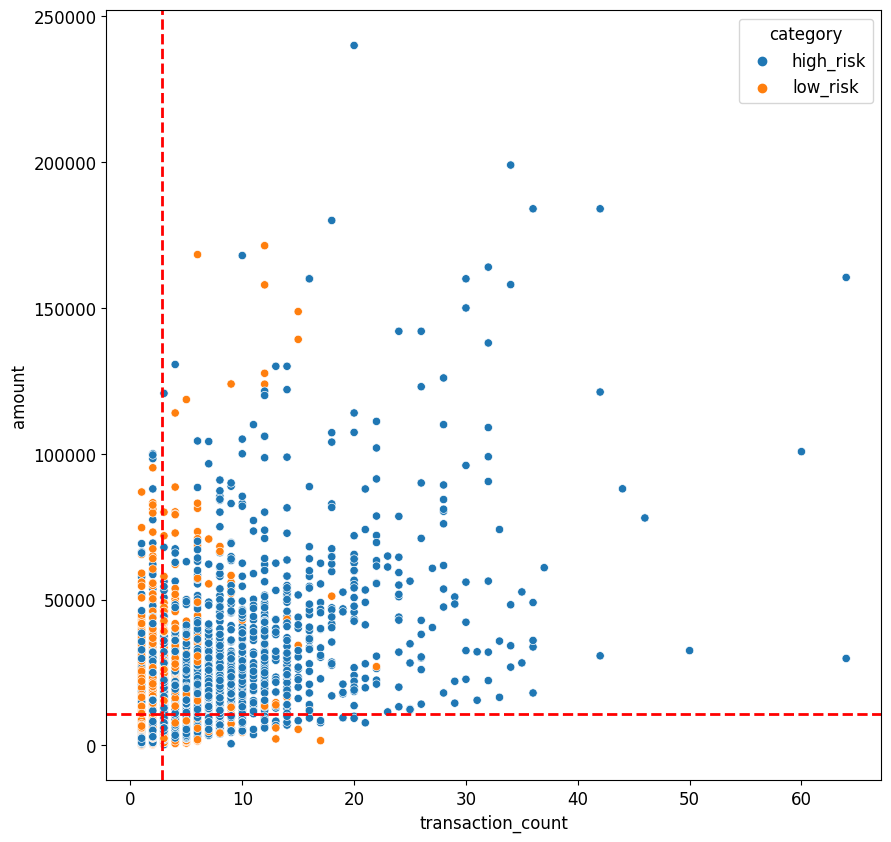

In [56]:
graph = final.query('period=="old"')
plt.figure(figsize=(10,10))
sns.scatterplot(x=graph['transaction_count'], y=graph['amount'], hue=graph['category'])
plt.axvline(graph['transaction_count'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axhline(graph['amount'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.show()

### Observations
* Upper right quadrant is marjority high risk
* Lower right quadrant is fairly balanced between high/low risk
* Upper left quadrant is majority low risk
* Lower left quadrant is another mixed bag, but due to low billing amount can be lowest priority for collections

Finally, let's apply the quadrants above to the current_bill dataset, and extract our final groupings!

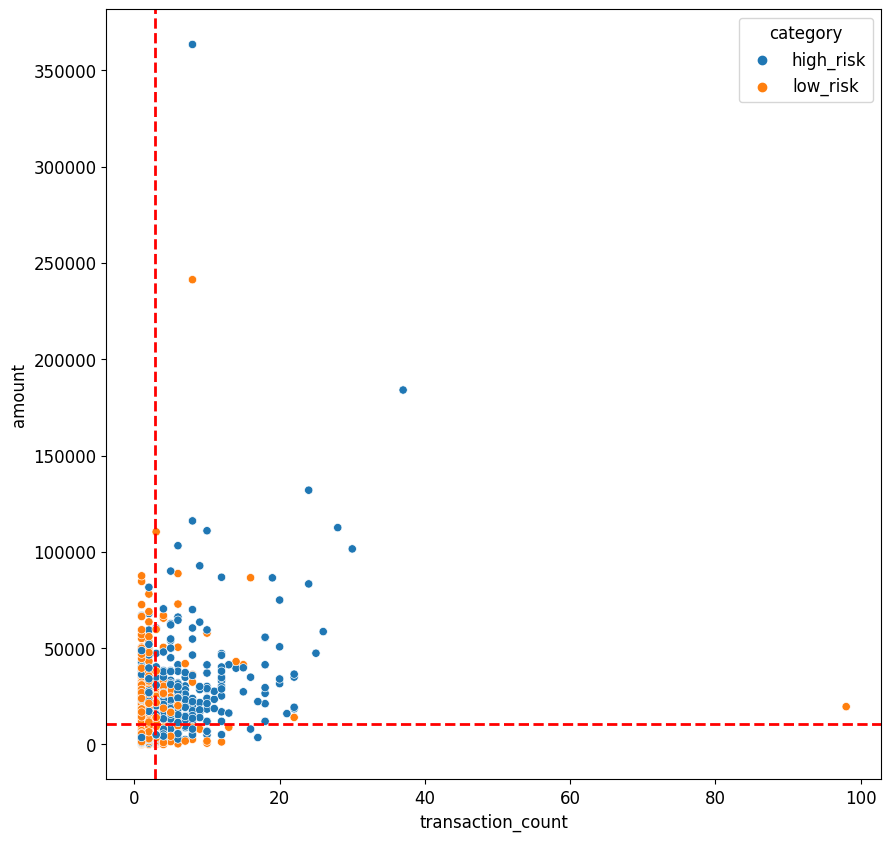

In [57]:
graph = final.query('period=="cur"')
plt.figure(figsize=(10,10))
sns.scatterplot(x=graph['transaction_count'], y=graph['amount'], hue=graph['category'])
plt.axvline(final.query('period=="old"')['transaction_count'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axhline(final.query('period=="old"')['amount'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.show()

Looks very similar to the first chart with the past data!

In [58]:
cur = final.query('period=="cur"')
old = final.query('period=="old"')
high_risk = cur[(cur['transaction_count'] > (old['transaction_count']).mean()) & (cur['amount'] > (old['amount']).mean())]
med_risk = cur[(cur['transaction_count'] > (old['transaction_count']).mean()) & (cur['amount'] < (old['amount']).mean())]
low_risk = cur[(cur['transaction_count'] < (old['transaction_count']).mean()) & (cur['amount'] > (old['amount']).mean())]
ignore = cur[(cur['transaction_count'] < (old['transaction_count']).mean()) & (cur['amount'] < (old['amount']).mean())]

### High risk
These users should be contacted with highest priority. Given the high bill value, every day after 5th until payment may be appropriate

In [59]:
high_risk['customer_id'].to_csv('high_risk_20211201.csv')

### Medium risk
These users should be contacted with the next highest priority. Bill value is lower, but risk is still relatively high. Calling every 2-3 days may be appropriate.

In [60]:
med_risk['customer_id'].to_csv('med_risk_20211201.csv')

### Low risk
These users should be contacted with lowest priority. Bill value is high, but their categories are of generally lower default risk than the other groups. Once every 4-7 days may be appropriate.

In [61]:
low_risk['customer_id'].to_csv('low_risk_20211201.csv')

# Final Thoughts

### Would like to get a hand on the following data for further analysis:
* Call data
    * Did customer answer?, customer sentiment (if tracked)
    * Having call data would also allow better focus in segments (can call high_risk group at every N days, med_risk at M days, etc.)
* Deeper customer data
    * Age, job/employment status?, payment type (credit/debit/etc.), full merchant account age
* Full billing data for 2021-12-01 (not just over 5 days late)
    
### Next steps/Improvements
* Gather more useful variables to apply to model and increase accuracy
* Datapoints still left unexplored
    * Location (city vs. rural splits)
* More past data could increase model accuracy